In [33]:
#!pip install --upgrade tensorflow-gpu==2.1.0rc0 tensorflow==2.1.0rc0

Requirement already up-to-date: tensorflow-gpu==2.1.0rc0 in /usr/local/lib/python3.6/dist-packages (2.1.0rc0)
  Using cached https://files.pythonhosted.org/packages/4d/fd/7528e5ef327abde9b7425aea24198d8b139795c1233d1658c1279055d860/tensorflow-2.1.0rc0-cp36-cp36m-manylinux2010_x86_64.whl
ERROR: Operation cancelled by user


In [0]:
 %tensorflow_version 2.x

In [35]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
import os
import re

#tf.config.experimental_run_functions_eagerly(True)
print(tf.__version__)

2.1.0-rc1


In [0]:
# Build the identity block
class IdentityBlock():
  def __init__(self, kernel_size, filters, name='', **kwargs):
    #super(IdentityBlock, self).__init__(**kwargs)
    self.kernel_size = kernel_size
    self.filters = filters
    self.expansion = 4
    self.base_name = name

    self.__build()
  
  def __build(self):
    self.conv1 = layers.Conv2D(self.filters, (1, 1), name=self.base_name+'conv1')
    self.bn1 = layers.BatchNormalization(name=self.base_name+'bn1')

    self.conv2 = layers.Conv2D(self.filters, self.kernel_size, padding='same', name=self.base_name+'conv2')
    self.bn2 = layers.BatchNormalization(name=self.base_name+'bn2')

    self.conv3 = layers.Conv2D(self.filters*self.expansion, (1, 1), name=self.base_name+'conv_expansion1')
    self.bn3 = layers.BatchNormalization(name=self.base_name+'bn_expansion1')


  def __call__(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = keras.activations.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = keras.activations.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)

    x = layers.add([x, input_tensor])
    return keras.activations.relu(x)

In [0]:
# Build the conv block
class ConvBlock():
  def __init__(self, kernel_size, filters, strides=(2, 2), name='', **kwargs):
    #super(ConvBlock, self).__init__(**kwargs)
    self.kernel_size = kernel_size
    self.filters = filters
    self.strides = strides
    self.expansion = 4
    self.base_name = name
    self.__build()


  def __build(self):
    self.conv1 = layers.Conv2D(self.filters, (1, 1), strides=self.strides, name=self.base_name+'conv1')
    self.bn1 = layers.BatchNormalization(name=self.base_name+'bn1')

    self.conv2 = layers.Conv2D(self.filters, self.kernel_size, padding='same', name=self.base_name+'conv2')
    self.bn2 = layers.BatchNormalization(name=self.base_name+'bn2')

    self.conv3 = layers.Conv2D(self.filters*self.expansion, (1, 1), name=self.base_name+'conv3')
    self.bn3 = layers.BatchNormalization(name=self.base_name+'bn3')

    self.shortcut_conv = layers.Conv2D(self.filters*self.expansion, (1, 1), strides=self.strides, name=self.base_name+'conv_skip')
    self.shortcut_bn = layers.BatchNormalization(name=self.base_name+'bn_exp')


  def __call__(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = keras.activations.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = keras.activations.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)

    shortcut = self.shortcut_conv(input_tensor)
    shortcut = self.shortcut_bn(shortcut)

    x = layers.add([x, shortcut])
    return keras.activations.relu(x)

In [0]:
# Build the ResNet
class ResNet():
  def __init__(self, classes=10):
    #super(ResNet, self).__init__(name='resnet-50')
    self._layers = []
    self.n_layers = [3, 4, 6, 3]
    self.classes = classes
    # According to paper
    self.filters = 64

  def build(self):
    filters = [64, 128, 256, 512]
    
    self._layers.append(layers.ZeroPadding2D(padding=(3, 3), name='head_padding1'))
    self._layers.append(layers.Conv2D(self.filters, (7, 7), strides=(2, 2), padding='valid', name='head_conv'))
    self._layers.append(layers.BatchNormalization(name='head_bn'))
    self._layers.append(layers.Activation('relu'))
    self._layers.append(layers.ZeroPadding2D(padding=(1, 1), name='head_padding2'))
    self._layers.append(layers.MaxPooling2D((3, 3), strides=(2, 2), name='head_max_pool'))
    #self.padd1 = layers.ZeroPadding2D(padding=(3, 3))
    #self.conv1 = layers.Conv2D(self.filters, (7, 7), strides=(2, 2), padding='valid')
    #self.bn1 = layers.BatchNormalization()

    #self.padd2 = layers.ZeroPadding2D(padding=(1, 1))
    #self.max1 = layers.MaxPooling2D((3, 3), strides=(2, 2))

    for i, l in enumerate(self.n_layers):
      for j in range(l):
        if i == 0 and j == 0:
          self._layers.append(ConvBlock((3, 3), filters[i], strides=(1, 1), name=f'{i}_conv_exp_L{j}_'))
        elif j == 0:
          self._layers.append(ConvBlock((3, 3), filters[i], name=f'{i}_conv_L{j}_'))
        else:
          self._layers.append(IdentityBlock((3, 3), filters[i], name=f'{i}_identity_L{j}_'))

    self._layers.append(layers.GlobalAveragePooling2D())
    self._layers.append(layers.Dense(self.classes, activation='softmax', name='fc'))
    #self.pool1 = layers.GlobalAveragePooling2D()
    #self.fc = layers.Dense(self.classes, activation='softmax')

  def __call__(self, input_tensor):
    self.build()
    #x = self.padd1(input_tensor)
    #x = self.conv1(x)
    #x = keras.activations.relu(self.bn1(x))

    #x = self.padd2(x)
    #x = self.max1(x)

    for i, _layer in enumerate(self._layers):
      if i == 0:
        x = _layer(input_tensor)
      else:
        x = _layer(x)
         
    #x = self.pool1(x)
    #x = self.fc(x)

    return keras.Model(input_tensor, x)

In [89]:
# Display model layers
model = ResNet(classes=10)(keras.Input(shape=(512, 512, 3)))
#model.load_weights(f'{DATASET_PATH}pretrained/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
model.summary()
#!ls

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
head_padding1 (ZeroPadding2D)   (None, 518, 518, 3)  0           input_44[0][0]                   
__________________________________________________________________________________________________
head_conv (Conv2D)              (None, 256, 256, 64) 9472        head_padding1[0][0]              
__________________________________________________________________________________________________
head_bn (BatchNormalization)    (None, 256, 256, 64) 256         head_conv[0][0]                  
___________________________________________________________________________________________

In [41]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Prepare data
DATASET_PATH    = '/content/drive/My Drive/retina_images/'
CHECKPOINT_PATH = DATASET_PATH + '/checkpoints/'
DATA_SRC_PATH   = DATASET_PATH + '/data/'

TEMP_PATH       = '/content/'
DATA_PATH       = TEMP_PATH + '/data/'

In [0]:
!unzip -q -n -d '{DATA_PATH}' '{DATASET_PATH+"/train_dst.zip"}'
!unzip -q -n -d '{DATA_PATH}' '{DATASET_PATH+"/test_dst.zip"}'

In [91]:
!dir '{DATA_PATH}/train_dst' | head
!dir '{DATA_PATH}/test_dst' | head

10003_left.jpeg   19968_left.jpeg   30000_left.jpeg   39972_right.jpeg
10003_right.jpeg  19968_right.jpeg  30000_right.jpeg  39975_left.jpeg
10007_left.jpeg   19970_left.jpeg   30004_left.jpeg   39975_right.jpeg
10007_right.jpeg  19970_right.jpeg  30004_right.jpeg  39978_left.jpeg
10009_left.jpeg   19972_left.jpeg   3000_left.jpeg    39978_right.jpeg
10009_right.jpeg  19972_right.jpeg  3000_right.jpeg   39981_left.jpeg
1000_left.jpeg	  19975_left.jpeg   30012_left.jpeg   39981_right.jpeg
1000_right.jpeg   19975_right.jpeg  30012_right.jpeg  39982_left.jpeg
10010_left.jpeg   19976_left.jpeg   30015_left.jpeg   39982_right.jpeg
10010_right.jpeg  19976_right.jpeg  30015_right.jpeg  39983_left.jpeg
10000_left.jpeg   19996_right.jpeg  29928_right.jpeg  39921_right.jpeg
10000_right.jpeg  19997_left.jpeg   29930_left.jpeg   39922_left.jpeg
10001_left.jpeg   19997_right.jpeg  29930_right.jpeg  39922_right.jpeg
10001_right.jpeg  19998_left.jpeg   29931_left.jpeg   39923_left.jpeg
10002_right.jp

In [0]:
!apt-get install libimage-size-perl

In [0]:
!imgsize '/content/data/train_dst/10003_left.jpeg'

In [92]:
train_labels = pd.read_csv(f'{DATASET_PATH}train_labels.csv')
test_labels = pd.read_csv(f'{DATASET_PATH}test_labels.csv')

classes = [0, 1, 2, 3, 4]

# Remove usage column
test_labels = test_labels.drop('Usage', axis=1)

train_labels['image'] = train_labels['image'].apply(lambda f: f'train_dst/{f}.jpeg')
test_labels['image'] = test_labels['image'].apply(lambda f: f'test_dst/{f}.jpeg')

data = pd.concat([train_labels, test_labels]).sample(frac=1)
data = data.dropna()

data

,image,level
10965,train_dst/13776_right.jpeg,0
3464,test_dst/2915_left.jpeg,2
7056,test_dst/5866_left.jpeg,2
9625,train_dst/12114_right.jpeg,0
3313,train_dst/4134_right.jpeg,0
...,...,...
32640,test_dst/27063_left.jpeg,0
19243,train_dst/24266_right.jpeg,0
14379,test_dst/11928_right.jpeg,0
40063,test_dst/33117_right.jpeg,2


([<matplotlib.axis.XTick at 0x7fa7cce68c18>,
 <a list of 5 Text xticklabel objects>)

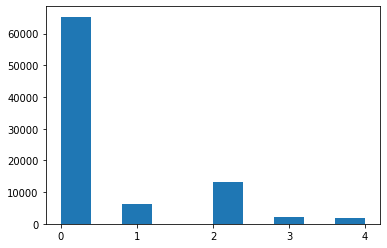

In [93]:
plt.hist(x=data['level'])
plt.xticks(classes)

In [0]:
# min_class = None

# for class_ in classes:
#   count = data.loc[data['level'] == class_].count()['level']
  
#   print('Count class "{}": {}'.format(class_, count))

#   if min_class is None:
#     min_class = count
#   elif count < min_class:
#     min_class = count
#   else:
#     continue
data_c0 = data.where(data['level'] == 0).dropna()
data_c0 = data_c0.iloc[:int(len(data_c0) * 0.20)]
data_cP = data.where(data['level'] > 0).dropna()

data = pd.concat([data_c0, data_cP]).sample(frac=1) # concat & shuffle data

split = int(len(data) * 0.1)
test_df = data.iloc[:split].copy()
train_df = data.iloc[split:].copy()

Because the 4th class ist the less represented, we will duplicate it and take the same amount of data for every class

In [0]:
# new_data = None

# for class_ in classes:
#   # Get all the rows for a given class
#   tmp = data.loc[data['level'] == class_]
#   # Get the count
#   count = tmp.count()['level']
  
#   # If the lowest represented class * 2 is bigger than
#   # the count itself we duplicate the dataframe
#   if min_class * 2 > count:
#     tmp_df = tmp.copy()
#     tmp = tmp.append(tmp_df)
#     tmp = tmp.iloc[:min_class]
#   else:
#     tmp = tmp.iloc[:min_class]

#   if class_ == 0:
#     new_data = pd.DataFrame(tmp)
#   else:
#     new_data = pd.concat([new_data, tmp])

In [0]:
plt.hist(x=data['level'])
plt.xticks(classes)

In [98]:
BATCH_SIZE = 32
IMG_SIZE = 384

datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    rotation_range=360,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='level',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    directory=DATA_PATH,
    validate_filenames=True)

validation_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='level',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    directory=DATA_PATH,
    validate_filenames=True)

Found 32716 validated image filenames.
Found 3634 validated image filenames.


/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 69 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 8 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [99]:
model = ResNet(classes=5)(keras.Input(shape=(512, 512, 3)))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_generator,
          epochs=10,
          validation_data=validation_generator,
          max_queue_size=16,
          workers=4, use_multiprocessing=False)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1023 steps, validate for 114 steps
Epoch 1/10
1023/1023 [==============================] - 711s 695ms/step - loss: 1.4022 - sparse_categorical_accuracy: 0.3706 - val_loss: 16.1844 - val_sparse_categorical_accuracy: 0.2036
Epoch 2/10
1023/1023 [==============================] - 686s 671ms/step - loss: 1.3706 - sparse_categorical_accuracy: 0.3704 - val_loss: 1.5469 - val_sparse_categorical_accuracy: 0.3500
Epoch 3/10
1023/1023 [==============================] - 685s 670ms/step - loss: 1.3633 - sparse_categorical_accuracy: 0.3816 - val_loss: 1.3710 - val_sparse_categorical_accuracy: 0.3751
Epoch 4/10
1023/1023 [==============================] - 674s 659ms/step - loss: 1.3705 - sparse_categorical_accuracy: 0.3641 - val_loss: 1.3539 - val_sparse_categorical_accuracy: 0.3509
Epoch 5/10
1023/1023 [==============================] - 676s 661ms/step - loss: 1.3670 - sparse_categorical_accuracy: 0.3668 - val_loss: 1.3804 - val_sparse_cat